In [51]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error #不太靠谱 太劲大求了。差的平方的均值
from sklearn.metrics import explained_variance_score #越小代表结果越差
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #交叉验证
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
X = pd.read_excel('input5.xlsx')
#X['dayofyear'] = X['日期'].apply(lambda x : x.dayofyear)
X['年份'] = X['日期'].apply(lambda x : x.year)
X['Day_of_week'] =  X['日期'].apply(lambda x: x.dayofweek)
X['Day_of_month'] = X['日期'].apply(lambda x: x.day)
X['前一天供水量'] = X['总供水量'].shift(1)
X['上周同天供水量'] = X['总供水量'].shift(2)
X['与前一天空气质量差'] = X['空气质量指数'] - X['空气质量指数'].shift(1)
X['与前一天湿度差值'] = X['平均相对湿度'] - X['平均相对湿度'].shift(1)
X['与前一天最低气温差'] = X['最低气温'] - X['最低气温'].shift(1)
X['与前一天最高气温差'] = X['最高气温'] - X['最高气温'].shift(1)
X['与前一天平均气温差'] = X['平均气温'] - X['平均气温'].shift(1)
X = X[~pd.isnull(X['上周同天供水量'])]
y = X.pop('总供水量')
#drop = ['日期','星期', 'PM2.5', 'PM10', 'SO2', 'CO', 'NO2', 'O3_8h']
drop = ['日期','星期']
data = X['日期']
X.drop(drop,axis = 1,inplace = True)
X_reset = X.reset_index(drop = True)
sunday_index = X_reset.loc[X_reset['节假日'] == '周末'].index
for i in sunday_index:
    if X_reset.loc[i,'Day_of_week'] == 6:
         X_reset.loc[i,'节假日'] = '周日'
    if X_reset.loc[i,'Day_of_week'] == 5:
         X_reset.loc[i,'节假日'] = '周六'
X_input = pd.get_dummies(X_reset)

In [52]:
for column in X_reset.columns:
    if isinstance(X_reset[column].values[0],str):
        X_reset[column] = pd.factorize(X_reset[column].values , sort=True)[0] + 1

In [33]:
import xgboost as xgb
import operator
import matplotlib.pyplot as plt
param = {
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'learning_rate': 0.07,
    'max_depth': 6,
    'min_child_weight': 4,
    'n_estimators': 110, 
    'reg_alpha': 0.1,
    'reg_lambda': 2,
    'subsample': 0.7
}

In [34]:
xgtrain = xgb.DMatrix(X_reset,y)
bst = xgb.train(param,xgtrain,num_boost_round=1000)
features = [x for x in X_reset.columns]
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w',encoding = 'utf8')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

<Figure size 432x288 with 0 Axes>

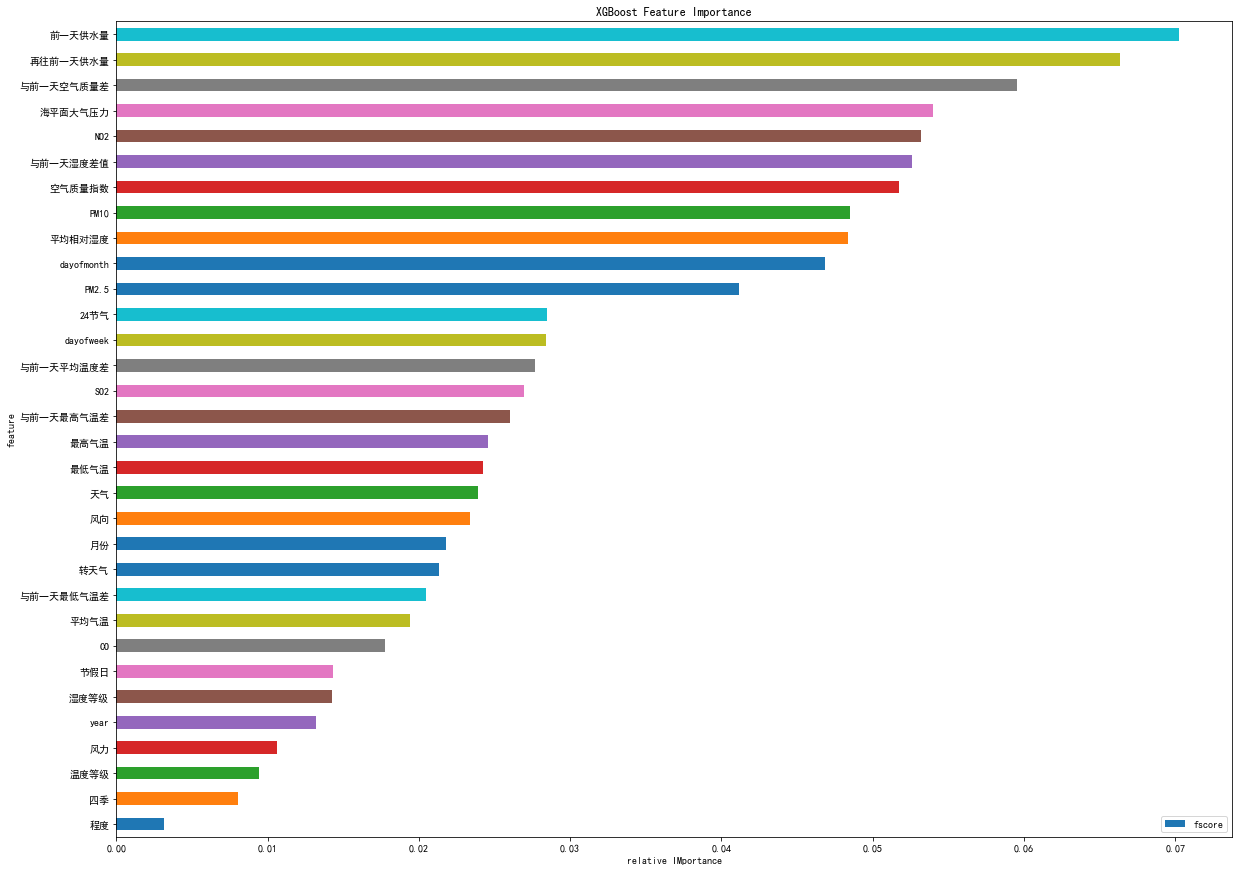

In [35]:
create_feature_map(features)
importance = bst.get_fscore(fmap = 'xgb.fmap')
importance = sorted(importance.items(),key = operator.itemgetter(1))
df = pd.DataFrame(importance,columns = ['feature','fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df.to_csv('feat_importance.csv',index = False)
plt.figure()
df.plot(kind = 'barh',x = 'feature',y = 'fscore',legend = 'False',figsize = (20,15))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative IMportance')
plt.show()

In [59]:
bag_reg = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,
                       max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
np.mean(-cross_val_score(bag_reg,X_input,y,cv = 10,scoring= 'neg_mean_absolute_error'))

74253.75725923853

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X_reset,y,test_size = 0.2)
#将整个数据集分成训练集和测试集，X_train和Y_train是训练集，其他两个是测试集
clf = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,
                       max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
#根据以上图 选择 最适合的参数
clf.fit(X_train,y_train)
#这一步是在训练模型
pre = clf.predict(X_test)
#这一步是对测试集做预测，输出pre就是预测值。
np.mean(abs(pre - y_test))

62495.3373015873

Text(0.5,1,'bagging平均偏差')

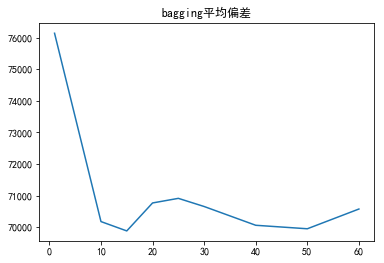

In [113]:
from sklearn.ensemble import BaggingRegressor
bag_params = [1,10,15,20,25,30,40,50,60]
bag_test_score = []
for par in bag_params:
    bag_reg = BaggingRegressor(n_estimators = par,base_estimator = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7))
    bag_test_score.append(np.mean(-cross_val_score(bag_reg,X_input,y,cv = 10,scoring= 'neg_mean_absolute_error')))
plt.plot(bag_params,bag_test_score)
plt.title("bagging平均偏差")

In [ ]:
bag_reg = BaggingRegressor(n_estimators = 50,base_estimator = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7))
(np.mean(-cross_val_score(bag_reg,X_input,y,cv = 10,scoring= 'neg_mean_absolute_error')))

In [53]:
from scipy.stats import pearsonr
dic = {}
for col in X_reset.columns:
    dic[col] = abs(pearsonr(X_reset[col],y)[0])
    #f.append(abs(pearsonr(X_reset[col],y)[0]))
dic['Day_of_week'] = 0.57
dic['NO2'] = 0.04
dic['天气'] = 0.75
dic['Day_of_month'] = 0.62
dic['污染程度'] = 0.40
dic['四季'] = 0.58
dic['平均相对湿度']  = 0.7
dic['空气质量指数'] = 0.48
dic['O3_8h'] = 0.05
dic['风力'] = 0.55
dic['月份'] = 0.30
dic['与前一天最高气温差'] = 0.65
dic['与前一天平均气温差'] = 0.15
dic['湿度等级'] = 0.12
dic['与前一天湿度差值'] = 0.50
li = dict(sorted(dic.items(),key = lambda x:x[1],reverse=True))

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 7 Text yticklabel objects>)

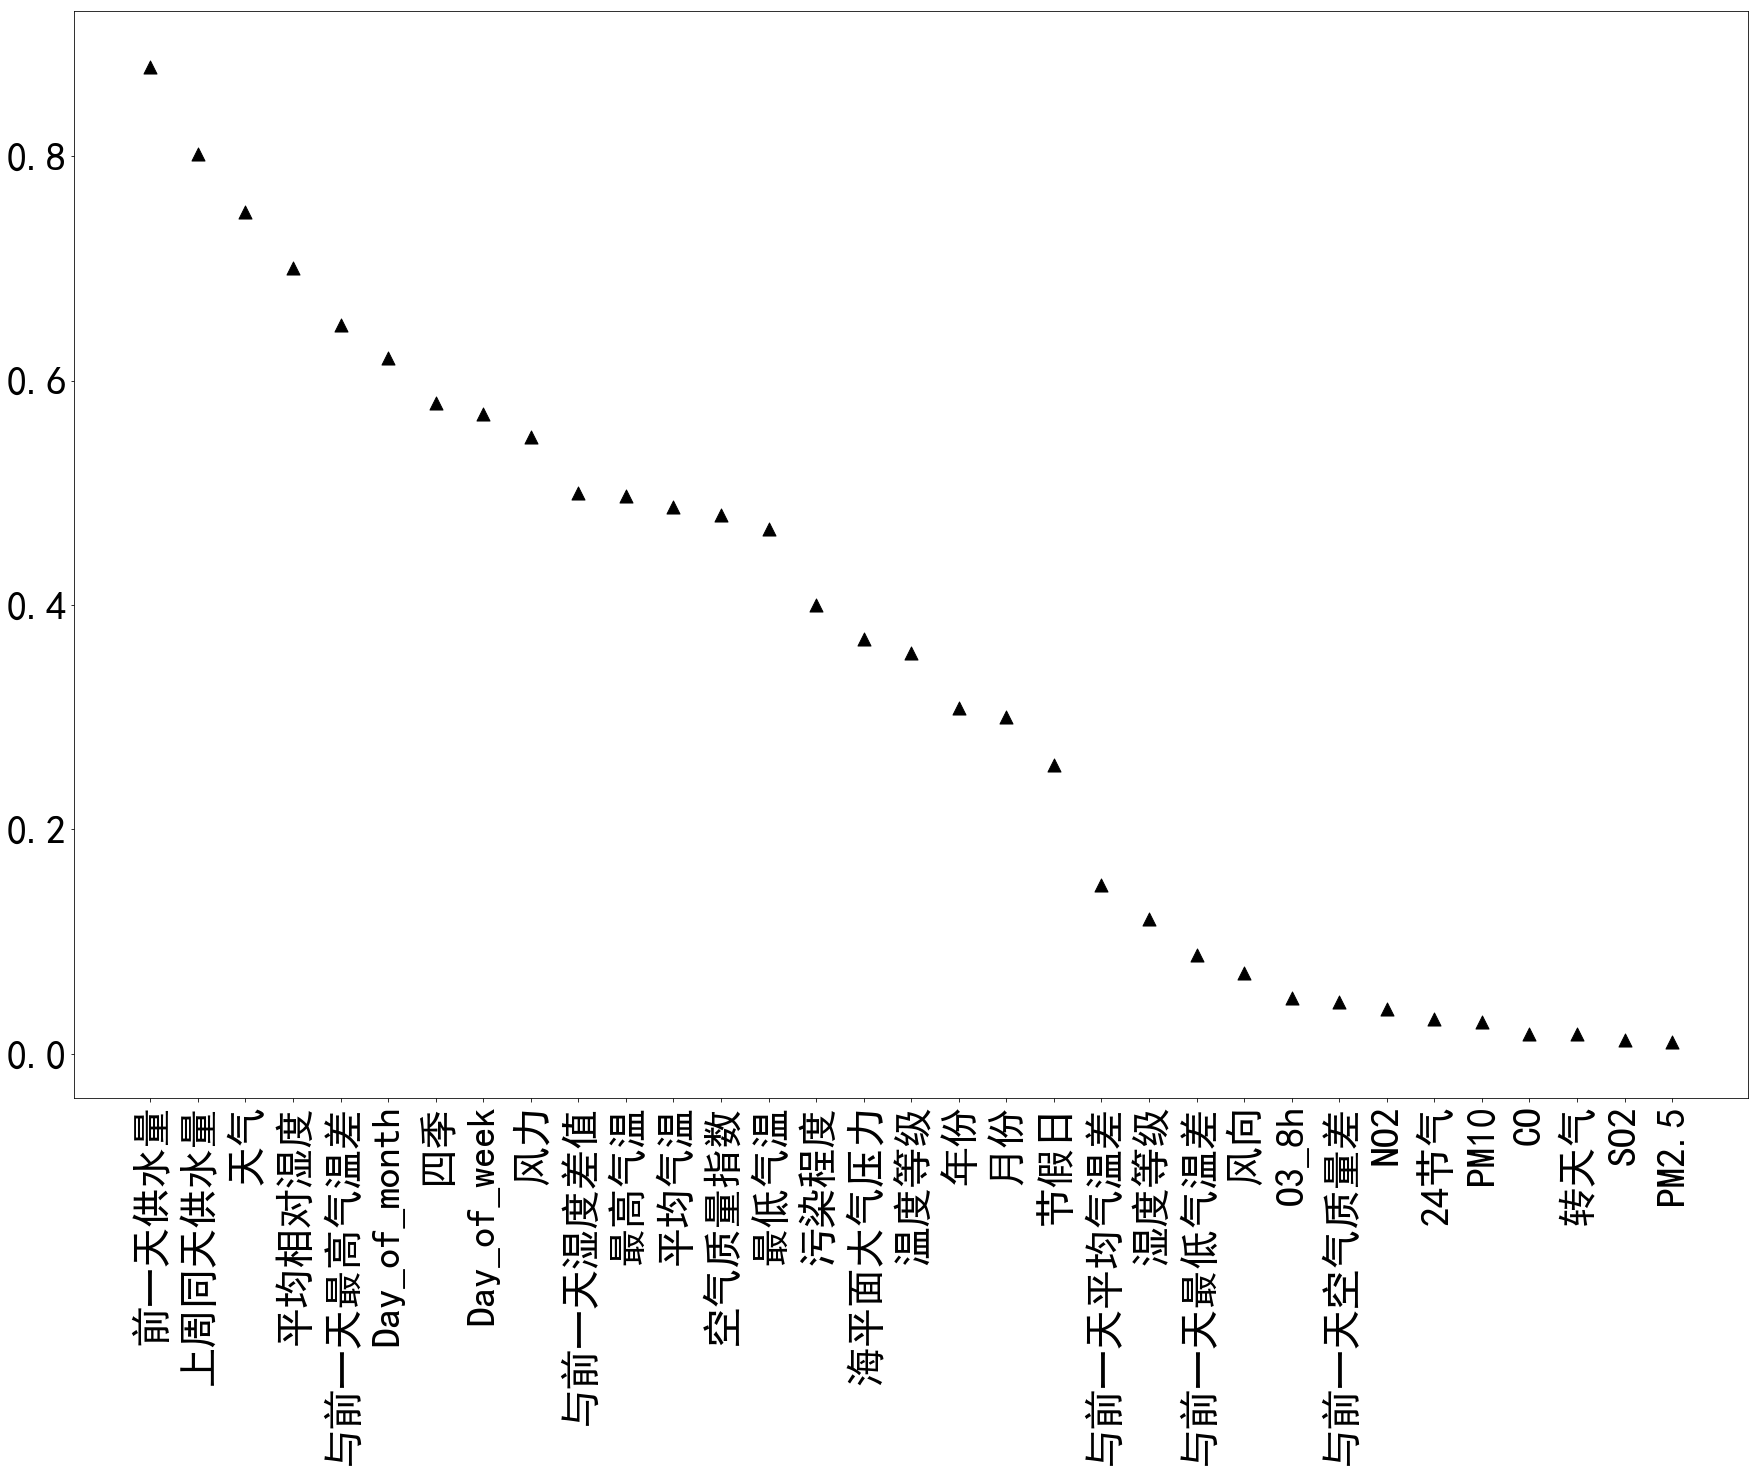

In [103]:
fig1 = plt.figure(figsize=(30,20))
plt.scatter(list(li.keys()),list(li.values()),s= 170,color = 'black',marker = '^')
plt.xticks(fontsize=40,rotation = 90)
plt.yticks(fontsize=40)
#x_line = np.arange(33)
#y_line = x_line*0 + 0.2
#plt.plot(x_line,y_line)
#plt.legend()

c:\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


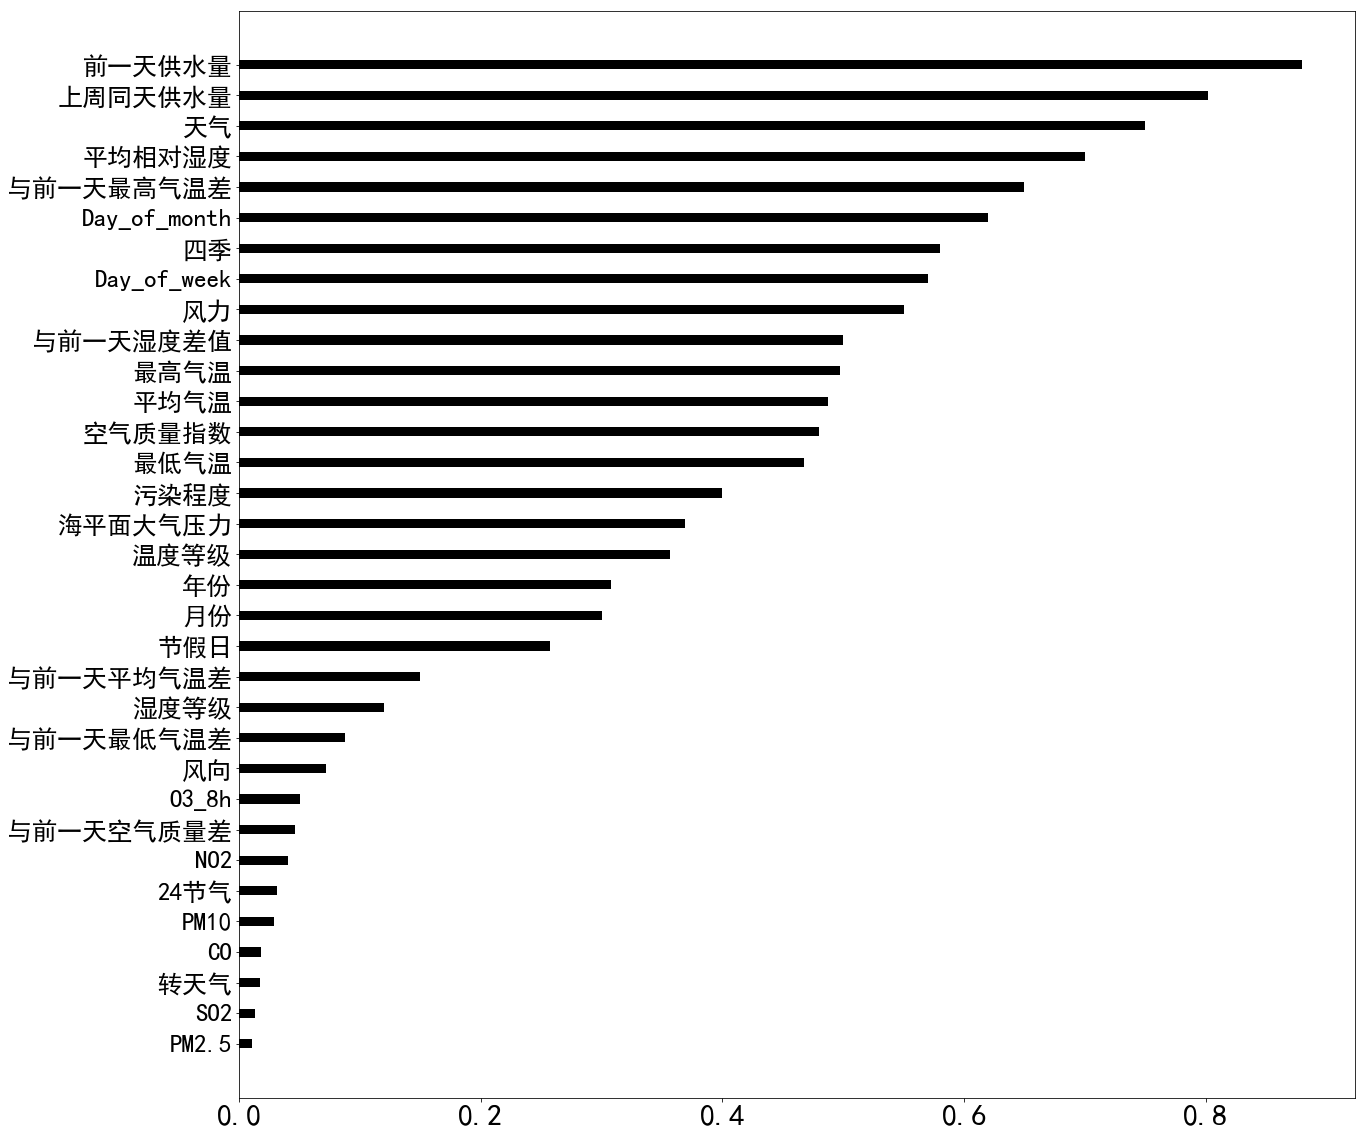

In [106]:
plt.savefig('pearson.png')
plt.barh(list(li.keys())[::-1],list(li.values())[::-1],facecolor = 'black',height=0.3)
plt.yticks(fontsize=25)
plt.xticks(fontsize=30)
ax = plt.subplot()
#plt.xlabel('pearson相关系数')
#ax.set_xlabel('pearson相关系数',fontsize = 35)
fig = matplotlib.pyplot.gcf() #获取当前的绘图对象
fig.set_size_inches(20, 20) #设置图像的大小


In [46]:
plt.savefig('pearson.png')

<Figure size 432x288 with 0 Axes>

In [108]:
X_in = X_reset[col]

In [112]:
bag_reg = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,
                       max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
np.mean(-cross_val_score(bag_reg,X_input,y,cv = 10,scoring= 'neg_mean_absolute_error'))

73136.78527435611

In [27]:
len(X_input)

942

c:\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


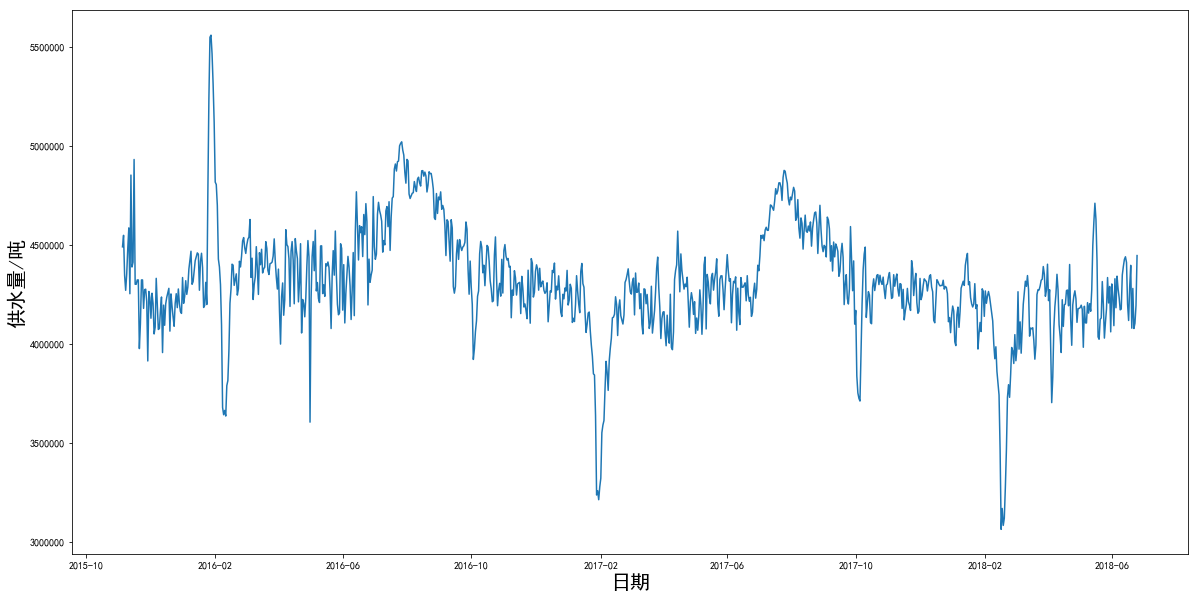

In [30]:
plt.plot(data,y)
fig = plt.gcf() #获取当前的绘图对象
fig.set_size_inches(20, 10) #设置图像的大小
ax = plt.subplot()
#plt.xlabel('pearson相关系数')
ax.set_ylabel('供水量/吨',fontsize = 20)
ax.set_xlabel('日期',fontsize = 20)
plt.savefig('test.pdf')
plt.show()